<a href="https://colab.research.google.com/github/anniebritton/Eco-Drought-South-Dakota/blob/main/NDVI_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Workbook Setup**

In [48]:
# install and import libraries
# !pip install scikit-learn
# !pip install lazypredict
# !pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit Learn
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.ensemble import ExtraTreesRegressor
import xgboost
from xgboost import XGBRegressor

# Other Tools
from lazypredict.Supervised import LazyRegressor
import shap

In [15]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Data**

In [16]:
normalized_df = pd.read_csv('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/CSVs/NDVI_clean_preprocessed_V3.csv')

In [17]:
normalized_df['date'] = pd.to_datetime(normalized_df['date'])
normalized_df = normalized_df.set_index('date')
normalized_df

,NDVI_anomaly_roll,swe_anomaly_roll,tmin_anomaly_roll,tmax_anomaly_roll,precip_anomaly_roll,pdsi_anomaly_roll,eddi30_anomaly_roll,eddi90_anomaly_roll,eddi180_anomaly_roll,spei30_anomaly_roll,spei90_anomaly_roll,spei180_anomaly_roll,spi30_anomaly_roll,spi90_anomaly_roll,spi180_anomaly_roll,palmerz_anomaly_roll
date,,,,,,,,,,,,,,,,
2000-02-29,0.78,0.02,3.87,3.20,0.59,0.57,0.33,0.19,0.50,0.18,-0.05,-0.46,0.82,0.34,-0.51,0.22
2000-03-05,0.36,-0.43,3.35,3.17,0.14,0.56,0.57,0.30,0.61,-0.06,-0.11,-0.66,0.70,0.33,-0.77,0.10
2000-03-10,0.29,-0.81,2.55,2.29,1.80,0.56,0.61,0.33,0.68,0.29,0.08,-0.68,1.12,0.65,-0.69,0.42
2000-03-15,0.07,-0.92,1.68,1.55,1.17,0.57,0.64,0.29,0.71,0.39,0.24,-0.69,1.22,0.84,-0.63,0.51
2000-03-20,0.01,-0.95,1.25,1.19,1.11,0.58,0.63,0.27,0.76,0.47,0.35,-0.71,1.30,0.97,-0.58,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-06,0.68,-0.48,1.73,1.59,-0.31,-0.25,0.90,1.15,1.27,-0.92,0.01,-0.66,-0.49,0.82,0.29,-0.32
2021-12-11,0.68,-0.51,1.59,1.53,0.10,-0.27,1.20,1.22,1.30,-1.25,-0.04,-0.63,-0.52,0.81,0.36,-0.42
2021-12-16,0.40,-0.51,1.54,1.40,0.12,-0.28,1.37,1.31,1.32,-1.43,-0.06,-0.56,-0.53,0.82,0.46,-0.48


#**Prelim ML Tests**

In [ ]:
# try a decision tree regressor
from sklearn import tree

X = normalized_df.iloc[:,1:16].values
Y = normalized_df.iloc[:,0:1].values.ravel()

clf = tree.DecisionTreeRegressor()

X_train = normalized_df.iloc[0:1272, 1:16].values
Y_train = normalized_df.iloc[0:1272, 0:1].values.ravel()
X_test = normalized_df.iloc[1272:1590, 1:16].values
Y_test = normalized_df.iloc[1272:1590, 0:1].values

clf.fit(X_train, Y_train)
Y_predicted = clf.predict(X_test)

# compare Y_predicted with Y_test
clf.score(X_test, Y_test)

0.18566242852836923

In [ ]:
# try support vector regression
from sklearn import svm

X = normalized_df.iloc[:,1:16].values
Y = normalized_df.iloc[:,0:1].values.ravel()

regr = svm.SVR()

X_train = normalized_df.iloc[0:1272, 1:16].values
Y_train = normalized_df.iloc[0:1272, 0:1].values.ravel()
X_test = normalized_df.iloc[1272:1590, 1:16].values
Y_test = normalized_df.iloc[1272:1590, 0:1].values

regr.fit(X_train, Y_train)
Y_predicted = regr.predict(X_test)

# compare Y_predicted with Y_test
regr.score(X_test, Y_test)

0.28959003661328364

#**Trying Out LazyPredict**

In [ ]:
# Regression
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

X_train = normalized_df.iloc[0:1272, 1:16].values
y_train = normalized_df.iloc[0:1272, 0:1].values.ravel()

X_test = normalized_df.iloc[1272:1590, 1:16].values
y_test = normalized_df.iloc[1272:1590, 0:1].values

rmodel, rprediction = reg.fit(X_train, X_test, y_train, y_test)

rmodel

 21%|██▏       | 9/42 [00:02<00:08,  3.75it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 71%|███████▏  | 30/42 [00:08<00:03,  3.73it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


100%|██████████| 42/42 [01:10<00:00,  1.67s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.57,0.59,0.66,0.20
HistGradientBoostingRegressor,0.54,0.56,0.67,0.45
BaggingRegressor,0.49,0.51,0.71,0.45
GradientBoostingRegressor,0.47,0.49,0.73,0.77
RandomForestRegressor,0.46,0.49,0.73,1.52
ExtraTreesRegressor,0.44,0.47,0.74,0.69
XGBRegressor,0.39,0.42,0.78,0.54
LarsCV,0.39,0.42,0.78,0.07
TweedieRegressor,0.38,0.41,0.78,0.07


# **Train Test Split**

In [6]:
X = normalized_df.iloc[:, 1:16].values
y = normalized_df.iloc[:, 0:1].values.ravel()

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size = .20)

#**K-fold Cross Validation for LazyPredict Regression**

In [ ]:
def k_fold_lp(data, target, k=5):
    # Create a KFold object with k folds
    kf = KFold(n_splits=k, shuffle = True, random_state=42)
    # Create an empty df to store scores for each fold
    scores = pd.DataFrame()
    # Loop over each fold
    for train_idx, test_idx in kf.split(data):
        # Split the data into train and test sets for this fold
        X_train, X_test = data[train_idx], data[test_idx]
        y_train, y_test = target[train_idx], target[test_idx]
        # Create a LazyRegressor model
        reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
        # Fit the model on the train data and make predictions on the test data
        models, predictions = reg.fit(X_train, X_test, y_train, y_test)
        # Append the score to the list of scores for this fold
        scores = scores.append(predictions)
    # Calculate the mean of all scores across all folds
    return scores

In [ ]:
mean_score = k_fold_lp(x_train, y_train)
mean_score = mean_score.sort_values(by = "Adjusted R-Squared", ascending = False)

 26%|██▌       | 11/42 [00:01<00:03,  7.85it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 64%|██████▍   | 27/42 [00:04<00:03,  3.92it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


 26%|██▌       | 11/42 [00:01<00:04,  7.56it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 64%|██████▍   | 27/42 [00:04<00:03,  4.25it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


 21%|██▏       | 9/42 [00:01<00:06,  5.21it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 64%|██████▍   | 27/42 [00:06<00:03,  4.28it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


 26%|██▌       | 11/42 [00:01<00:04,  7.45it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 74%|███████▍  | 31/42 [00:06<00:02,  4.67it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


 26%|██▌       | 11/42 [00:01<00:03,  8.17it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 64%|██████▍   | 27/42 [00:04<00:03,  4.06it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


100%|██████████| 42/42 [00:35<00:00,  1.19it/s]


In [ ]:
mean_score.groupby("Model").mean().sort_values(by = "Adjusted R-Squared", ascending = False)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.90,0.91,0.29,0.59
GaussianProcessRegressor,0.90,0.90,0.31,0.17
HistGradientBoostingRegressor,0.87,0.87,0.35,0.78
XGBRegressor,0.86,0.87,0.35,0.98
LGBMRegressor,0.86,0.87,0.35,0.19
RandomForestRegressor,0.85,0.86,0.37,1.43
BaggingRegressor,0.81,0.82,0.41,0.13
GradientBoostingRegressor,0.77,0.78,0.46,0.68
KNeighborsRegressor,0.75,0.77,0.47,0.03


#**K-Fold on Individual Models**

In [ ]:
import xgboost as xgb

# Define your model
xgb_model = xgb.XGBRegressor()

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Run k-fold cross validation on the model
results = cross_val_score(xgb_model, x_train, y_train, cv=kfold, scoring='r2')

# Print the mean and standard deviation of the results
print("Results:", results)
print("Mean Result:", results.mean())

Results: [0.83344137 0.88264041 0.87159841 0.92189001 0.84966984]
Mean Result: 0.8718480086208835


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

# Define your model
etr_model = ExtraTreesRegressor()

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Run k-fold cross validation on the model
results = cross_val_score(etr_model, x_train, y_train, cv=kfold, scoring='r2')

# Print the mean and standard deviation of the results
print("Results:", results)
print("Mean Result:", results.mean())

Results: [0.87281767 0.92869947 0.89026584 0.94301502 0.89990347]
Mean Result: 0.9069402917029921


#**Hyperparameter Optimization** - Random Search

In [ ]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'learning_rate': uniform(0.015, 0.07),
    'max_depth': randint(8, 15),
    'min_child_weight': randint(1, 6),
    'subsample': uniform(0.55, 0.85),
    'colsample_bytree': uniform(0.8, 1),
    'n_estimators': randint(350, 550)
}

# Define the regression model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the random search object
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, cv=kfold, n_iter=100, random_state=42, verbose=3)

# Fit the random search to the training data
random_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)


################################# History #####################################
########### Round 1

# param_dist = {
#     'learning_rate': uniform(0.01, 1),
#     'max_depth': randint(0, 15),
#     'min_child_weight': randint(0, 15),
#     'subsample': uniform(0.01, 1),
#     'colsample_bytree': uniform(0.01, 1),
#     'n_estimators': randint(1, 1000)
# }

# Best hyperparameters:  {'colsample_bytree': 0.6520316461542878, 'learning_rate': 0.09413996499504883, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 422, 'subsample': 0.6789882547142286}
# Best score:  0.8909438160811403

########### Round 2
# param_dist = {
#     'learning_rate': uniform(0.01, 0.5),
#     'max_depth': randint(3, 15),
#     'min_child_weight': randint(1, 12),
#     'subsample': uniform(0.5, 0.9),
#     'colsample_bytree': uniform(0.6, 0.7),
#     'n_estimators': randint(300, 600)
# }

# Best hyperparameters:  {'colsample_bytree': 0.9120829269975137, 'learning_rate': 0.059987457909001445, 'max_depth': 13, 'min_child_weight': 8, 'n_estimators': 399, 'subsample': 0.6285801361297467}
# Best score:  0.8932270704629971

########### Round 3
# param_dist = {
#     'learning_rate': uniform(0.01, 0.3),
#     'max_depth': randint(3, 20),
#     'min_child_weight': randint(1, 15),
#     'subsample': uniform(0.5, 0.85),
#     'colsample_bytree': uniform(0.5, 1),
#     'n_estimators': randint(300, 550)
# }

# Best hyperparameters:  {'colsample_bytree': 0.7441255222477742, 'learning_rate': 0.06048731265187917, 'max_depth': 11, 'min_child_weight': 4, 'n_estimators': 412, 'subsample': 0.5551584100426343}
# Best score:  0.895306234565564

########### Round 4
# param_dist = {
#     'learning_rate': uniform(0.01, 0.2),
#     'max_depth': randint(5, 15),
#     'min_child_weight': randint(2, 10),
#     'subsample': uniform(0.45, 0.75),
#     'colsample_bytree': uniform(0.6, .95),
#     'n_estimators': randint(350, 550)
# }

# Best hyperparameters:  {'colsample_bytree': 0.8319192461353855, 'learning_rate': 0.043658208434586114, 'max_depth': 12, 'min_child_weight': 2, 'n_estimators': 529, 'subsample': 0.7227222017844706}
# Best score:  0.9012786182370087

########### Round 5
# param_dist = {
#     'learning_rate': uniform(0.01, 0.1),
#     'max_depth': randint(8, 15),
#     'min_child_weight': randint(1, 8),
#     'subsample': uniform(0.45, 0.85),
#     'colsample_bytree': uniform(0.70, .95),
#     'n_estimators': randint(350, 600)
# }

# Best hyperparameters:  {'colsample_bytree': 0.9752638802680795, 'learning_rate': 0.026122128725400443, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 394, 'subsample': 0.7012886329620569}
# Best score:  0.901620715612505

########### Round 6
# param_dist = {
#     'learning_rate': uniform(0.015, 0.07),
#     'max_depth': randint(8, 15),
#     'min_child_weight': randint(1, 6),
#     'subsample': uniform(0.55, 0.85),
#     'colsample_bytree': uniform(0.8, 1),
#     'n_estimators': randint(350, 550)
# }

# Best hyperparameters:  {'colsample_bytree': 0.8330507329005484, 'learning_rate': 0.039154987361867816, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 475, 'subsample': 0.6731606412775397}
# Best score:  0.9031405024181771

In [ ]:
# Load your data
X = normalized_df.iloc[:, 1:15].values
y = normalized_df.iloc[:, 0:1].values.ravel()

# Define the distribution of hyperparameters to search over
param_dist = {
    'n_estimators': range(1100, 1900, 25),
    'max_depth':  range(10, 55, 5),
    'min_samples_split': range(1, 3),
    'min_samples_leaf': range(1, 3),
    'max_features': [1.0],
    'bootstrap': [False],
}

# Define the regression model
etr = ExtraTreesRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the random search object
random_search = RandomizedSearchCV(etr, param_distributions=param_dist, cv=kfold, n_iter=100, random_state=42, verbose=3)

# Fit the random search to the training data
random_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)


################################# History #####################################
########### Round 1

# param_dist = {
#     'n_estimators': range(100, 2000, 100),
#     'max_depth':  [None] + list(range(5, 51, 5)),
#     'min_samples_split': range(2, 21),
#     'min_samples_leaf': range(1, 21),
#     'max_features': [1.0, 'sqrt', 'log2', None],
#     'bootstrap': [False, True],
# }

# Best hyperparameters:  {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': 45, 'bootstrap': False}
# Best score:  0.9187203478854071

########### Round 2
# param_dist = {
#     'n_estimators': range(500, 3000, 100),
#     'max_depth':  [None] + list(range(5, 61, 5)),
#     'min_samples_split': range(2, 10),
#     'min_samples_leaf': range(1, 10),
#     'max_features': ['sqrt', 'log2', None],
#     'bootstrap': [False],
# }

# Best hyperparameters:  {'n_estimators': 1100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 35, 'bootstrap': False}
# Best score:  0.8975296278159837

########### Round 3
# param_dist = {
#     'n_estimators': range(500, 2000, 100),
#     'max_depth':  [None] + list(range(15, 55, 5)),
#     'min_samples_split': range(1, 10),
#     'min_samples_leaf': range(1, 7),
#     'max_features': [1.0, None],
#     'bootstrap': [False],
# }

# Best hyperparameters:  {'n_estimators': 1300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 45, 'bootstrap': False}
# Best score:  0.9127688839685864

########### Round 4
# param_dist = {
#     'n_estimators': range(1000, 2000, 25),
#     'max_depth':  range(25, 65, 5),
#     'min_samples_split': range(1, 5),
#     'min_samples_leaf': range(1, 4),
#     'max_features': [1.0],
#     'bootstrap': [False],
# }

# Best hyperparameters:  {'n_estimators': 1750, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 25, 'bootstrap': False}
# Best score:  0.9131749629654576

########### Round 5
# param_dist = {
#     'n_estimators': range(1100, 1900, 25),
#     'max_depth':  range(10, 55, 5),
#     'min_samples_split': range(1, 3),
#     'min_samples_leaf': range(1, 3),
#     'max_features': [1.0],
#     'bootstrap': [False],
# }

# Best hyperparameters:  {'n_estimators': 1325, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 25, 'bootstrap': False}
# Best score:  0.9131999031220314

#**Hyperparameter Optimization** - Grid Search

In [ ]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'learning_rate': [0.039, 0.0391],
    'max_depth': [8],
    'min_child_weight': [3],
    'subsample': [0.673, 0.674, 0.675],
    'colsample_bytree': [0.832, 0.833, 0.834],
    'n_estimators': [473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484]
}

############### Score to Beat:
# Best hyperparameters:  {'colsample_bytree': 0.8330507329005484, 'learning_rate': 0.039154987361867816, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 475, 'subsample': 0.6731606412775397}
# Best score:  0.9031405024181771

# param_dist = {
#     'learning_rate': [0.039, 0.0392, 0.0394],
#     'max_depth': [8],
#     'min_child_weight': [3],
#     'subsample': [0.672, 0.675, 0.678],
#     'colsample_bytree': [0.83, 0.833, 0.835],
#     'n_estimators': [470, 472, 475, 477, 479]
# }

# Best hyperparameters:  {'colsample_bytree': 0.83, 'learning_rate': 0.039, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 479, 'subsample': 0.675}
# Best score:  0.89639462035717

# Best hyperparameters:  {'colsample_bytree': 0.832, 'learning_rate': 0.0391, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 483, 'subsample': 0.673}
# Best score:  0.8971286041227069

# Best hyperparameters:  {'colsample_bytree': 0.832, 'learning_rate': 0.0391, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 484, 'subsample': 0.673}
# Best score:  0.8971356117203955


# Define the regression model
xgb = XGBRegressor(objective='reg:squarederror')

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the search object
grid_search = GridSearchCV(xgb, param_dist, cv=kfold, verbose = 3)

# Fit the random search to the training data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

In [ ]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'n_estimators': [1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334],
    'max_depth': [25],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [1.0],
    'bootstrap': [False],
}

############### Score to Beat:
# Best hyperparameters:  {'n_estimators': 1325, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 25, 'bootstrap': False}
# Best score:  0.9131999031220314

# param_dist = {
#     'n_estimators': [1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345],
#     'max_depth': [25],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1],
#     'max_features': [1.0],
#     'bootstrap': [False],
# }

# Best hyperparameters:  {'bootstrap': False, 'max_depth': 25, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1330}
# Best score:  0.9135005826681157

# param_dist = {
#     'n_estimators': [1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334],
#     'max_depth': [25],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1],
#     'max_features': [1.0],
#     'bootstrap': [False],
# }

# Best hyperparameters:  {'bootstrap': False, 'max_depth': 25, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1330}
# Best score:  0.9134521139884099

# Define the regression model
etr = ExtraTreesRegressor()

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the search object
grid_search = GridSearchCV(etr, param_dist, cv=kfold, verbose = 3)

# Fit the random search to the training data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# **Tuning Results**

In [10]:
# XGBoost:
# Best hyperparameters:  {'colsample_bytree': 0.8331, 'learning_rate': 0.0392, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 475, 'subsample': 0.6732}
# Best score:  0.9031

# Extra Trees:
# Best hyperparameters:  {'bootstrap': False, 'max_depth': 25, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1330}
# Best score:  0.9135

# **Train and Test**

In [35]:
# For ease, train test split code chunk again:
X = normalized_df.iloc[:, 1:16].values
y = normalized_df.iloc[:, 0:1].values.ravel()

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size = .20)

In [36]:
# XGBoost
# Define the model based on the best parameters
xg_reg = XGBRegressor(colsample_bytree = 0.8331,
                      learning_rate = 0.0392,
                      max_depth = 8,
                      min_child_weight = 3,
                      n_estimators = 475,
                      subsample = 0.6732)

# Fit the model to the training data
xg_reg.fit(x_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = xg_reg.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Squared Error: 0.102360055963141
Root Mean Squared Error: 0.31993758135477146
R-squared: 0.9016194022884273


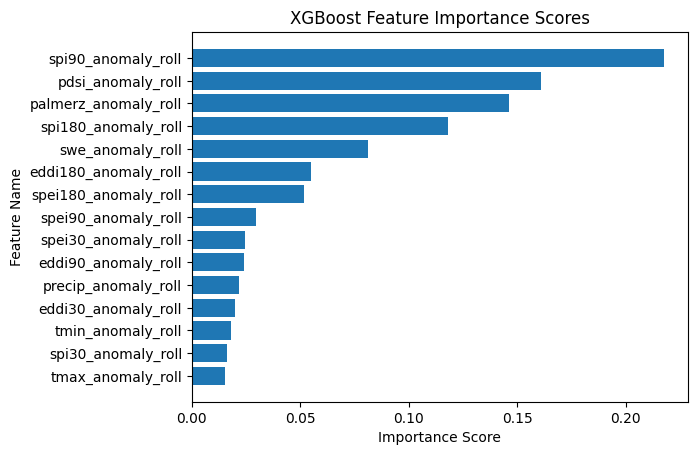

In [42]:
# XGB
# Get feature importance scores
importance = xg_reg.feature_importances_

# Create a list of feature names
features = list(normalized_df.columns[1:16])

# Create a dictionary of feature importance scores and feature names
feature_importance = dict(zip(features, importance))

# Sort the dictionary by feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance ranking
# print("Feature Importance Ranking:")
# for feature, importance_score in sorted_feature_importance:
#     print(feature, ":", importance_score)

# Create a list of feature names and importance scores, in reverse order
features = [x[0] for x in reversed(sorted_feature_importance)]
importance_scores = [x[1] for x in reversed(sorted_feature_importance)]

# Create a horizontal bar chart
plt.barh(features, importance_scores)

# Add a title and axis labels
plt.title('XGBoost Feature Importance Scores')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')

# Display the chart
plt.show()

In [39]:
# ETR
# Define the ExtraTreesRegressor model
et_reg = ExtraTreesRegressor(bootstrap=False,
                               max_depth=25,
                               max_features=1.0,
                               min_samples_leaf=1,
                               min_samples_split=2,
                               n_estimators=1330)

# Fit the model to the training data
et_reg.fit(x_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = et_reg.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Squared Error: 0.07285212964180147
Root Mean Squared Error: 0.26991133663075634
R-squared: 0.929980147125923


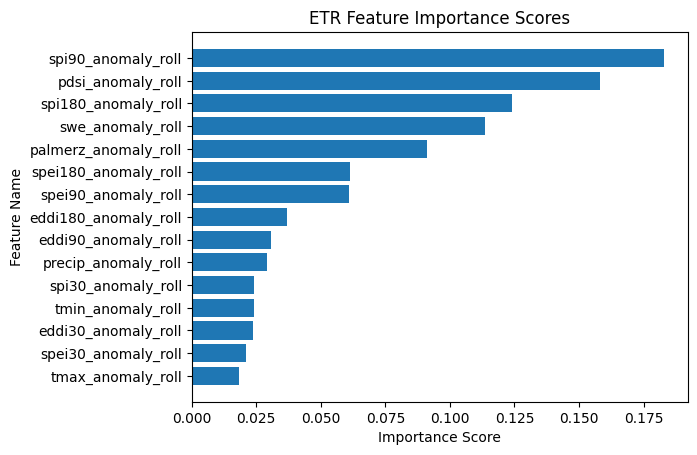

In [41]:
# ETR
# Get feature importance scores
importance = et_reg.feature_importances_

# Create a list of feature names
features = list(normalized_df.columns[1:16])

# Create a dictionary of feature importance scores and feature names
feature_importance = dict(zip(features, importance))

# Sort the dictionary by feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance ranking
# print("Feature Importance Ranking:")
# for feature, importance_score in sorted_feature_importance:
#     print(feature, ":", importance_score)

# Create a list of feature names and importance scores, in reverse order
features = [x[0] for x in reversed(sorted_feature_importance)]
importance_scores = [x[1] for x in reversed(sorted_feature_importance)]

# Create a horizontal bar chart
plt.barh(features, importance_scores)

# Add a title and axis labels
plt.title('ETR Feature Importance Scores')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')

# Display the chart
plt.show()

# **XAI**

In [68]:
#create a feature name variable that should match the below
feature_names = ['SWE', 'Min Temp', 'Max Temp',
       'Precipitation', 'PDSI', 'EDDI 30-Day',
       'EDDI 90-Day', 'EDDI 180-Day', 'spei30-Day',
       'SPEI 90-Day', 'SPEI 180-Day', 'SPI 30-Day',
       'SPI 90-Day', 'SPI 180-Day', 'Palmer Z']

normalized_df.columns[1:16]

Index(['swe_anomaly_roll', 'tmin_anomaly_roll', 'tmax_anomaly_roll',
       'precip_anomaly_roll', 'pdsi_anomaly_roll', 'eddi30_anomaly_roll',
       'eddi90_anomaly_roll', 'eddi180_anomaly_roll', 'spei30_anomaly_roll',
       'spei90_anomaly_roll', 'spei180_anomaly_roll', 'spi30_anomaly_roll',
       'spi90_anomaly_roll', 'spi180_anomaly_roll', 'palmerz_anomaly_roll'],
      dtype='object')

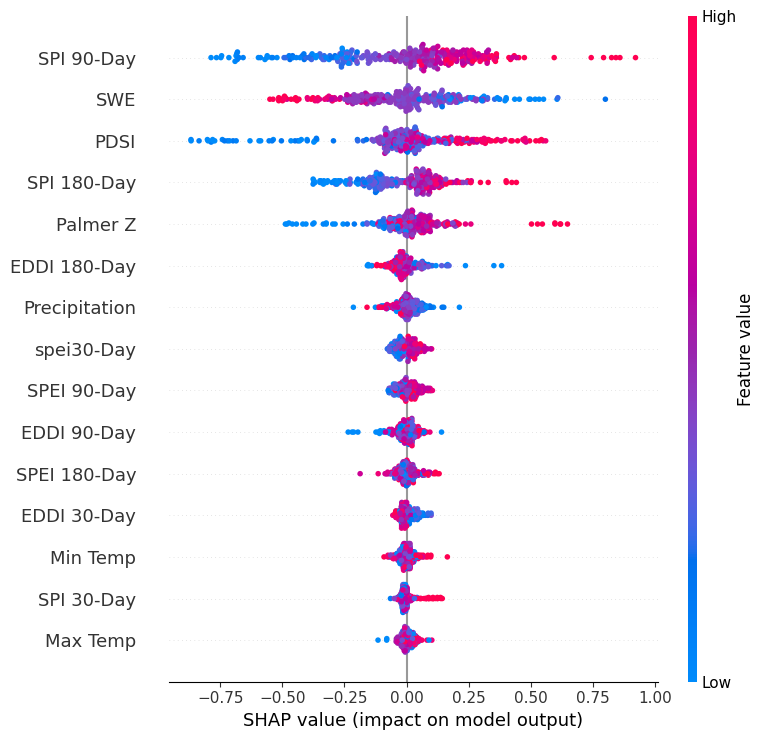

In [66]:
# XGBoost
# Define the model based on the best parameters
xg_reg = XGBRegressor(colsample_bytree = 0.8331,
                      learning_rate = 0.0392,
                      max_depth = 8,
                      min_child_weight = 3,
                      n_estimators = 475,
                      subsample = 0.6732)

# Fit the model to the training data
xg_reg.fit(x_train, y_train)

# Use the model to make predictions
xg_y_pred = xg_reg.predict(x_test)

# Explain results using SHAP
xg_explainer = shap.Explainer(xg_reg)
xg_shap_values = xg_explainer(x_test)

# Summary plot
shap.summary_plot(xg_shap_values, features=x_test, feature_names=feature_names)

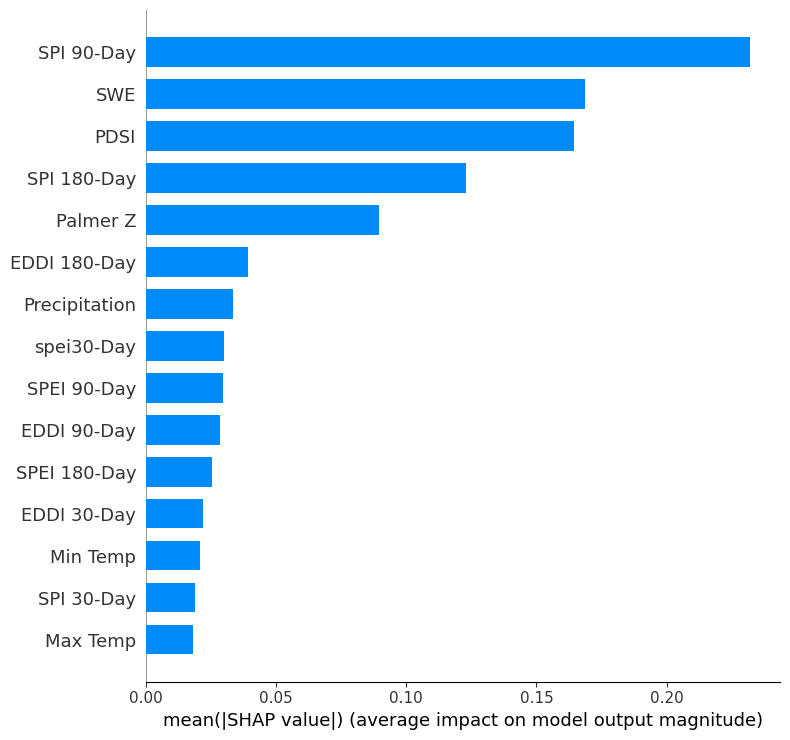

In [69]:
# create a bar plot showing the above
shap.summary_plot(xg_shap_values, features=x_test, feature_names=feature_names,plot_type="bar")

In [70]:
shap.initjs()
shap.force_plot(xg_explainer.expected_value, xg_shap_values.values, x_test, feature_names=feature_names)
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Force%20Plot%20Colors.html

# For force_plot I would add only the following - there is a drop box in the upper-middle region of the graph. 
# Use it to see what the plot shows you for cp - most important feature and chol - least important feature. 
# For cp the width of its band is large, whereas for chol it's not.

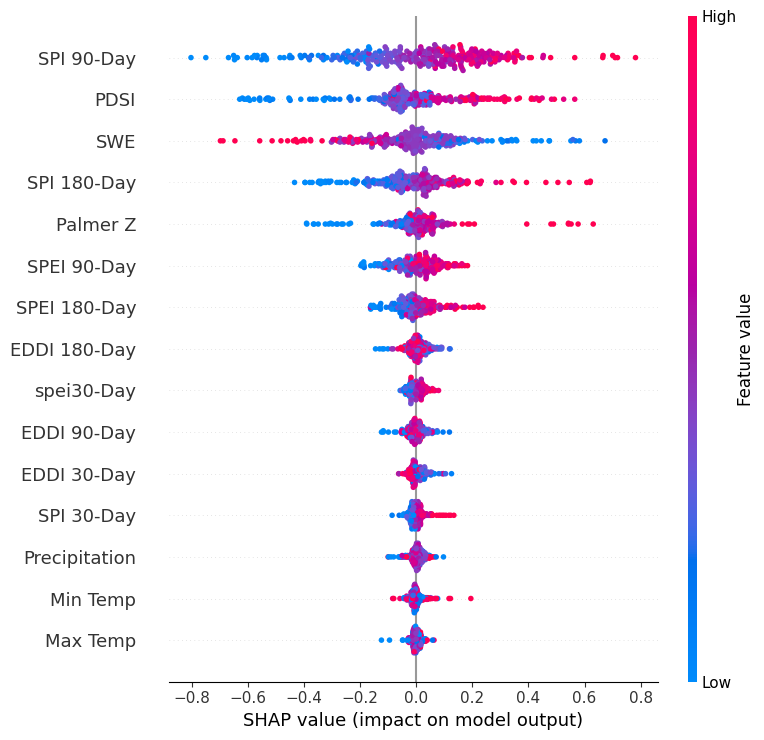

In [71]:
# Define the ExtraTreesRegressor model
et_reg = ExtraTreesRegressor(bootstrap=False,
                               max_depth=25,
                               max_features=1.0,
                               min_samples_leaf=1,
                               min_samples_split=2,
                               n_estimators=1330)

# Fit the model to the training data
et_reg.fit(x_train, y_train)

# Use the model to make predictions
et_y_pred = et_reg.predict(x_test)

# Explain results using SHAP
et_explainer = shap.Explainer(et_reg)
et_shap_values = et_explainer(x_test)

# Summary plot
shap.summary_plot(et_shap_values, features=x_test, feature_names=feature_names)

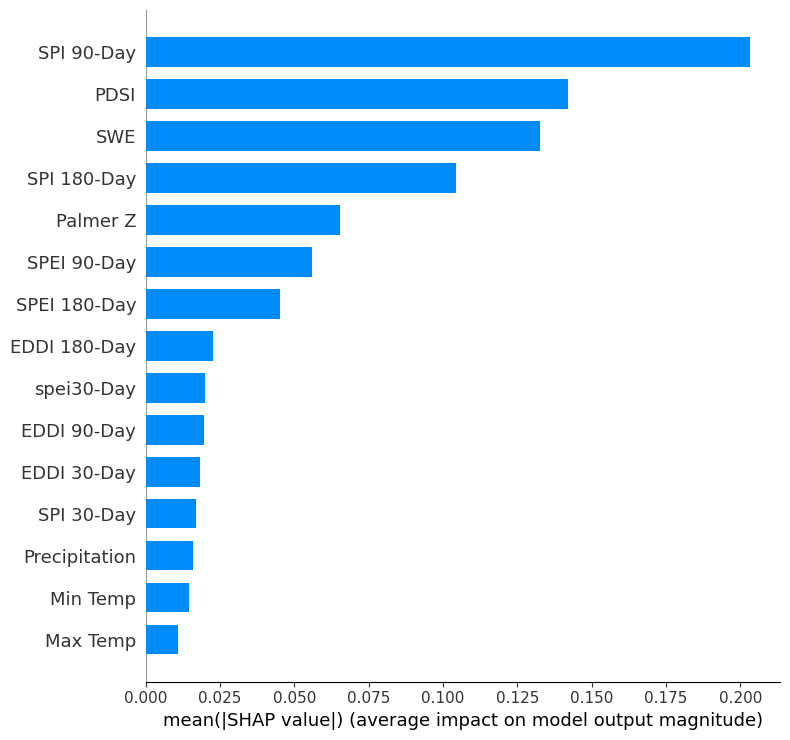

In [73]:
# create a bar plot showing the above
shap.summary_plot(et_shap_values, features=x_test, feature_names=feature_names,plot_type="bar")

In [72]:
shap.initjs()
shap.force_plot(et_explainer.expected_value, et_shap_values.values, x_test, feature_names=feature_names)
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Force%20Plot%20Colors.html

# For force_plot I would add only the following - there is a drop box in the upper-middle region of the graph. 
# Use it to see what the plot shows you for cp - most important feature and chol - least important feature. 
# For cp the width of its band is large, whereas for chol it's not.

# **Interpretation Notes**

Feature importance scores and SHAP (SHapley Additive exPlanations) feature values are both ways to measure the importance of features in a machine learning model, but they are calculated differently and provide different information.

Feature importance scores are typically calculated using a model-specific method that measures the contribution of each feature to the overall prediction accuracy of the model. These scores can be used to identify which features are most important for the model's performance and to make decisions about which features to include or exclude from the model. However, feature importance scores do not provide information about how each feature contributes to individual predictions.

SHAP feature values, on the other hand, are based on the concept of Shapley values from cooperative game theory and provide a way to measure the contribution of each feature to a specific prediction made by the model. These values are calculated by considering all possible combinations of features and measuring how much each feature contributes to the difference between the model's prediction and a baseline prediction (such as the average prediction of the model). SHAP values can help to explain why a particular prediction was made by the model and can be used for tasks such as model debugging, explaining model predictions to stakeholders, and identifying data points with high feature importance.

In summary, feature importance scores are useful for identifying important features for the model's performance, while SHAP feature values provide more detailed information about how each feature contributes to individual predictions.

The force plot created using the SHAP library helps in interpreting the impact of features on the predicted output of a machine learning model. The force plot provides a visualization of how much each feature in a particular data point contributes to the final prediction made by the model.

In the code snippet provided, the XGBRegressor model is being used to predict a target variable. The SHAP library is used to explain the model's predictions by calculating SHAP values for the test set. SHAP values represent the impact of each feature on the predicted output.

The force plot created using SHAP library visualizes the contributions of each feature to the final prediction for a particular data point. The y-axis of the force plot represents the features in the dataset, and the x-axis represents the contribution of each feature towards the predicted output.

Each data point in the force plot represents a single prediction, and the color of each data point indicates the value of the feature. The red color indicates higher values, and the blue color indicates lower values.

In the code snippet provided, the force plot is created for the predictions made by the XGBRegressor model. By looking at the force plot, you can interpret the contribution of each feature in the prediction made by the model. You can also observe which features are positively or negatively correlated with the predicted output. The force plot can help in understanding how the model is making its predictions and which features are most important in determining the output.